# 6102 Applied Statistics, Final Project

### Author: Audrey Yang

#### Date: 27 April, 2025

## Package Imports

In [705]:
!pip install tqdm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange

import warnings

warnings.filterwarnings('ignore')

## Data Preprocessing (\& Import)

We first import and pre-process the data into a usable format.

The data are stored in two components. We process the component with the sequential chord data first below. 

### Chords Data Preprocessing

To do this, we define a dictionary and store the piece title as the key and the list of timestamps and chords as the item. The data are stored across 10 files, so we ingest the data from each file and concatenate them into one list.

In [40]:
music_types = ["orchestra", "piano"]
music_eras = ["baroque", "classical", "romantic", "modern", "addon"]

chords_data = {}

for music_type in music_types :
    for music_era in music_eras :
        filename = f"./project_data/chords-chordino_{music_type}_{music_era}.csv"

        piece_name = None
        piece_chords = None

        with open(filename, 'r') as f:
            for line in f:
                triple = line.split(",")

                if triple[0] != "" :
                    chords_data[piece_name] = piece_chords
                    
                    piece_name = triple[0].split("/")[1][:-1]
                    piece_chords = []
                else :
                    chord = triple[2][1:-2]
                    if chord != "N" :   
                        piece_chords.append((triple[1], chord))

chords_data.pop(None)

We display the length of the `chords_data` list and output the first ten chords of the first song to ensure that it looks correct.

In [43]:
len(chords_data), chords_data["CrossEra-0001_Albinoni__sinata_a_cinque_no._6_in_g_minor_op._2_1_adagio.mp3"][0:10]

(1990,
 [('0.400000000', 'G_min'),
  ('2.300000000', 'D_min'),
  ('2.800000000', 'Eb_maj'),
  ('4.500000000', 'Bb_maj'),
  ('5.100000000', 'A_dim'),
  ('7.300000000', 'D_maj'),
  ('9.000000000', 'A_min_min7'),
  ('9.500000000', 'G_maj'),
  ('11.700000000', 'C_min'),
  ('12.300000000', 'D_maj_min7')])

### Pieces Data Preprocessing

We now process the second component of the data, where the rows are the piece titles and the pieces' attributes. This is simpler, and we simply split the line by comma to process the file as a `csv`.

In [46]:
pieces_data = {}

filename = "./project_data/cross-era_annotations.csv"

with open(filename, 'r') as f :
    col_names = f.readline()[:-2]
    col_names = col_names[:1] + col_names[2:]
    for line in f :
        data_row = line.split(",")[:-1]

        title = data_row[1]
        data_row = data_row[:1] + data_row[2:]
        
        pieces_data[title] = data_row

In [48]:
len(pieces_data), pieces_data['CrossEra-0001_Albinoni__sinata_a_cinque_no._6_in_g_minor_op._2_1_adagio.mp3']

(2000,
 ['orchestra_baroque',
  'CrossEra-0001',
  'orchestra',
  'G',
  'minor',
  'Albinoni; Tomaso',
  '1671-1751',
  'Italy'])

In [50]:
keep_pieces = []
toss_pieces = []

for title in pieces_data :
    try :
        chords_data[title]
        keep_pieces.append(title)

    except :
        toss_pieces.append(title)

for piece in keep_pieces :
    if pieces_data[piece][5] == ' major' :
        pieces_data[piece] = pieces_data[piece][:4] + [""] + pieces_data[piece][6:] + [""]

In [266]:
addon_mapping = {"Bach; Carl Philipp Emanuel" : "baroque", "Beethoven; Ludwig van" : "classical", "Debussy; Claude" : "modern", "Mahler; Gustav" : "romantic", "Mozart; Leopold" : "baroque", "Ravel; Maurice" : "modern", "Rossini; Gioacchino" : "classical", "Scarlatti; Domenico" : "baroque", "Schubert; Franz" : "classical", "Sibelius; Jean" : "romantic", "Stamitz; Johann" : "baroque", "Strauss; Richard" : "romantic", "Telemann; Georg Philipp" : "baroque", "Weber; Carl Maria von" : "romantic"}

addon_mapping_gpt = {"Bach; Carl Philipp Emanuel": "classical",
                     "Beethoven; Ludwig van": "classical",
                     "Debussy; Claude": "modern",
                     "Mahler; Gustav": "romantic",
                     "Mozart; Leopold": "baroque",
                     "Ravel; Maurice": "modern",
                     "Rossini; Gioacchino": "classical",
                     "Scarlatti; Domenico": "baroque",
                     "Schubert; Franz": "romantic",
                     "Sibelius; Jean": "romantic",
                     "Stamitz; Johann": "classical",
                     "Strauss; Richard": "romantic",
                     "Telemann; Georg Philipp": "baroque",
                     "Weber; Carl Maria von": "romantic"}

addon_mapping_transitions_gpt = {"Bach; Carl Philipp Emanuel": "baroque-classical",
                              "Beethoven; Ludwig van": "classical-romantic",
                              "Debussy; Claude": "impressionist",
                              "Mahler; Gustav": "romantic",
                              "Mozart; Leopold": "baroque",
                              "Ravel; Maurice": "impressionist",
                              "Rossini; Gioacchino": "classical-romantic",
                              "Scarlatti; Domenico": "baroque",
                              "Schubert; Franz": "classical-romantic",
                              "Sibelius; Jean": "romantic-modern",
                              "Stamitz; Johann": "baroque-classical",
                              "Strauss; Richard": "romantic-modern",
                              "Telemann; Georg Philipp": "baroque",
                              "Weber; Carl Maria von": "classical-romantic"
}


pieces_info = {}
pieces_info_gpt = {}
pieces_info_transition = {}
pieces_composers = {}

for piece in keep_pieces :
    piece_features = pieces_data[piece]

    era = piece_features[0].split("_")[1]
    gpt_era = piece_features[0].split("_")[1]
    transition_era = piece_features[0].split("_")[1]
    composer = piece_features[5]
    composer_years = list(piece_features[6].split("-"))
    composer_country = piece_features[7]
    addon = -1

    if era == "addon" :
        try :
            era = addon_mapping[composer]
            gpt_era = addon_mapping_gpt[composer]
            transition_era = addon_mapping_transitions_gpt[composer]
            addon = 1
        except :
            era = ""

    instrumentation = piece_features[2]
    key = piece_features[3]
    mode = piece_features[4]
    
    pieces_info[piece] = [era, instrumentation, key, mode, addon]
    pieces_info_gpt[piece] = [gpt_era, instrumentation, key, mode, addon]
    pieces_info_transition[piece] = [transition_era, instrumentation, key, mode, addon]

    pieces_composers[piece] = [composer] + composer_years + [composer_country]

In [268]:
key_types = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
mod_types = ['flat', 'sharp', '']
mode_types = ['major', 'minor']

keys = []
key_mapping = {}

for key in key_types :
    for mod in mod_types :
        for mode in mode_types :
            if mod == "" :
                keys.append(key + "_" + mode)
            else :
                keys.append(key + "_" + mod + "_" + mode)

mod_mapping = {"flat" : "b", "sharp" : "#", "" : ""}
    
for key in key_types :
    for mod in mod_types :
        key_val = key + "_" + mod
        if mod == "" :
            key_mapping[key] = key.upper()
        else :
            key_mapping[key + "_" + mod] = key.upper()

In [270]:
counter = 0

for piece in keep_pieces :
    if pieces_info[piece][2] == "" :
        for key in keys :
            if key in piece :
                counter += 1
                pieces_info[piece][2] = key_mapping[key[:-6]]
                pieces_info[piece][3] = key[-5:]

In [272]:
pieces_info["CrossEra-1607_Beethoven_egmont_overture_op.84.mp3"]

['classical', 'orchestra', '', '', 1]

## Data Processing

### Sequential Chord Data Processing

In [276]:
def chord_name_processing(chords) :
    return [chord.split("_")[0] for chord in chords]

def chord_processing(chords, tonic) :
    fifths_mapping = {"C":1, "G":2, "D":3, "A":4, "E":5, "B":6, "F#":7, "Gb":7, "C#":8, "Db":8, "G#":9, "Ab":9, "D#":10, "Eb":10, "A#":11, "Bb":11, "F":12}
    chords = chord_name_processing(chords)

    try :
        offset = fifths_mapping[tonic]
    
        chords = [(fifths_mapping[chord] - offset + 1) if (fifths_mapping[chord] - offset + 1) > 0 else (fifths_mapping[chord] - offset + 13) for chord in chords]
    
        intervals_mapping = {1 : "I", 2 : "V", 3 : "II", 4 : "VI", 5 : "III", 6 : "VII", 7 : "T", 8 : "II", 9 : "VI", 10 : "III", 11 : "VII", 12: "IV"}
        mapped_chords = [intervals_mapping[chord] for chord in chords]

    except KeyError :

        if (chords[0] == chords[-1]) :
            tonic = chords[0]
        else :
            tonic = max(set(chords), key = chords.count)

        offset = fifths_mapping[tonic]
    
        chords = [(fifths_mapping[chord] - offset + 1) if (fifths_mapping[chord] - offset + 1) > 0 else (fifths_mapping[chord] - offset + 13) for chord in chords]
    
        intervals_mapping = {1 : "I", 2 : "V", 3 : "II", 4 : "VI", 5 : "III", 6 : "VII", 7 : "T", 8 : "II", 9 : "VI", 10 : "III", 11 : "VII", 12: "IV"}
        mapped_chords = [intervals_mapping[chord] for chord in chords]

    return mapped_chords
        
def chord_frequencies(chords) :
    intervals_ordering = {"I":1, "II":2, "III":3, "IV": 4, "T":5, "V":6, "VI":7, "VII":8}

    chord_frequencies = [0] * 8

    try :
        for chord in chords :
            chord_frequencies[intervals_ordering[chord] - 1] += 1
    except KeyError :
        return [None] * 8
        
    return chord_frequencies


We now test the above code to ensure that it is working properly.

In [65]:
test_chords = [chords[1] for chords in chords_data[keep_pieces[0]]]
mapped_chords = chord_processing(test_chords, pieces_data[keep_pieces[0]][3])

Print the mapped-to-tonic chords, written in Roman numerals (a tritone is marked as `T`).

In [68]:
mapped_chords[0:10]

['I', 'V', 'VI', 'III', 'II', 'V', 'II', 'I', 'IV', 'V']

We now get the chord frequencies.

In [71]:
chord_freqs = chord_frequencies(mapped_chords)
chord_freqs = [freq/sum(chord_freqs) for freq in chord_freqs]

chord_freqs

[0.18604651162790697,
 0.11627906976744186,
 0.16279069767441862,
 0.13953488372093023,
 0.0,
 0.23255813953488372,
 0.09302325581395349,
 0.06976744186046512]

Using the above function, we extract the features that we will use in all classification problems, including the first and last chord, the length of the piece, and the average time between chords.

In [278]:
pieces_features = {}
pieces_features_gpt = {}
pieces_features_transition = {}
chords_sequences = {}

for piece in keep_pieces :
    chords = [chord[1] for chord in chords_data[piece]]
    chord_sequence = chord_processing(chord_name_processing(chords), key)

    chords_sequences[piece] = chord_sequence

    first_chord = chord_sequence[0]
    last_chord = chord_sequence[-1]

    length = float(chords_data[piece][-1][0])
    interval_gap = np.mean(np.array([float(chord[0]) for chord in chords_data[piece]]))

    pieces_info[piece][2] = pieces_info[piece][2].strip()

    features = pieces_info[piece][:4] + [first_chord, last_chord, length, interval_gap]
    gpt_features = pieces_info_gpt[piece][:4] + [first_chord, last_chord, length, interval_gap]
    transition_gpt_features = pieces_info_transition[piece][:4] + [first_chord, last_chord, length, interval_gap]


    pieces_features[piece] = features
    pieces_features_gpt[piece] = gpt_features
    pieces_features_transition[piece] = transition_gpt_features

## The Classification Problem

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier

### Attempt 0: No Chord Features

In [80]:
data_nochords = pd.DataFrame([pieces_info[piece][:4] for piece in keep_pieces], columns = ['era', 'instrumentation', 'key', 'mode'])

class_map = {"baroque" : 1, "classical" : 2, "romantic" : 3, "modern" : 4}

data_nochords["era"] = data_nochords["era"].map(lambda x : class_map[x])

# data_nochords['key'].value_counts()

In [301]:
X = data_nochords[list(data_nochords.columns)[1:]]
y = data_nochords['era']

In [303]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
            
hgb = HistGradientBoostingClassifier(categorical_features = ['instrumentation', 'key', 'mode'], tol = 1e-5)

hgb.fit(X_train, y_train)
hgb.score(X_test, y_test)

0.5150753768844221

### Attempt 0: Cheating with Years

In [880]:
data_cheating = pd.concat((data_nochords, pd.Series([year[0] for year in composer_years], name = "year")), axis = 1)

X = data_cheating[list(data_cheating.columns)[1:]]
y = data_cheating['era']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
            
hgb = HistGradientBoostingClassifier(categorical_features = ['instrumentation', 'key', 'mode'], tol = 1e-5)

hgb.fit(X_train, y_train)
hgb.score(X_test, y_test)

0.992462311557789

### Attempt 1: Chord Frequencies Only

In [92]:
music_list = []

for piece in keep_pieces :
    chord_freqs = chord_frequencies(chords_sequences[piece])
    chord_freqs = [freq / sum(chord_freqs) for freq in chord_freqs]

    music_list.append(pieces_features[piece] + chord_freqs)
    
column_names = ["era", "instrumentation", "key", "mode", "first_chord", "last_chord", "length", "interval_gap", "I", "II", "III", "IV", "T", "V", "VI", "VII"]

data_chordfreqs = pd.DataFrame(music_list, columns = column_names)
data_chordfreqs["era"] = data_chordfreqs["era"].map(lambda x : class_map[x])

In [121]:
X = data_chordfreqs[list(data_chordfreqs.columns)[1:]]
y = data_chordfreqs['era']

learning_rates = [0.001, 0.01, 0.25, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1.0]
max_leaves = [10, 25, 50, 75, 100, 150, 200]

iterations = 10

scores = {}

for rate in range(len(learning_rates)) :
    for max_leaf in range(len(max_leaves)) :
        avg_score = 0
        
        for _ in range(iterations):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
            
            hgb1 = HistGradientBoostingClassifier(categorical_features = ['instrumentation', 'key', 'mode', 'first_chord', 'last_chord'],
                                                 learning_rate = learning_rates[rate], 
                                                 max_leaf_nodes = max_leaves[max_leaf],
                                                 tol = 1e-5)

            hgb1.fit(X_train, y_train)
            avg_score += hgb1.score(X_test, y_test)

        scores[(rate, max_leaf)] = avg_score / iterations

pairing = max(scores, key = scores.get)
print(pairing, scores[pairing])

(5, 4) 0.6668341708542713


In [122]:
rate_opt = learning_rates[pairing[0]]
leaves_opt = max_leaves[pairing[1]]

train_score = 0
test_score = 0

iterations = 1000

for _ in range(iterations) :
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    hgb_classifier1 = HistGradientBoostingClassifier(categorical_features = ['instrumentation', 'key', 'mode', 'first_chord', 'last_chord'],
                                                    learning_rate = rate_opt, 
                                                    max_leaf_nodes = leaves_opt,
                                                    tol = 1e-5,)
    
    hgb_classifier1.fit(X_train, y_train)
    train_score += hgb_classifier1.score(X_train, y_train)
    test_score += hgb_classifier1.score(X_test, y_test)

print((train_score / iterations, test_score / iterations))

(1.0, 0.6501608040201007)


### Attempt 2: Transitions, Layer 1

In [210]:
labels = {"I":1, "II":2, "III":3, "IV": 4, "T":5, "V":6, "VI":7, "VII":8}
transition_labels = []

for i in labels :
    for j in labels :
        transition_labels.append(i + '-' + j)

def get_transition_matrix(chords) :
    if len(chords) < 2:
        return np.zeros(64)

    transitions = np.zeros((8, 8))

    for i in range(len(chords) - 1) :
        transitions[labels[chords[i]] - 1][labels[chords[i + 1]] - 1] += 1
        
    transitions = transitions / np.sum(transitions, axis = 1).reshape(-1, 1)
    transitions = transitions.reshape(-1, 1).T
    
    return transitions

In [212]:
music_list = []

for piece in keep_pieces :
    chord_freqs = chord_frequencies(chords_sequences[piece])
    chord_freqs = [freq / sum(chord_freqs) for freq in chord_freqs]

    transition_probs = get_transition_matrix(chords_sequences[piece])

    music_list.append(pieces_features[piece] + chord_freqs + transition_probs.tolist()[0])
    
column_names = ["era", "instrumentation", "key", "mode", "first_chord", "last_chord", "length", "interval_gap", "I", "II", "III", "IV", "T", "V", "VI", "VII"] + transition_labels
drop_columns = ['I-VII', 'II-VII', 'III-VII', 'IV-VII', 'V-VII', 'VI-VII', 'VII-VII']
data_transitions = pd.DataFrame(music_list, columns = column_names)
data_transitions["era"] = data_transitions["era"].map(lambda x : class_map[x])
data_transitions = data_transitions.drop(axis = 1, inplace = False)

In [99]:
X = data_transitions[list(data_transitions.columns)[1:]]
y = data_transitions['era']

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

hgb_classifier = HistGradientBoostingClassifier(categorical_features = ['instrumentation', 'mode', 'key', 'first_chord', 'last_chord'],
                                                learning_rate = 0.25, 
                                                max_leaf_nodes = 20,
                                                tol = 1e-5,)

hgb_classifier.fit(X_train, y_train)
hgb_classifier.score(X_test, y_test)

0.7110552763819096

In [127]:
X = data_transitions[list(data_transitions.columns)[1:]]
y = data_transitions['era']

learning_rates = [0.001, 0.01, 0.25, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1.0]
max_leaves = [10, 25, 50, 75, 100, 150, 200]

iterations = 10

scores = {}

for rate in range(len(learning_rates)) :
    for max_leaf in range(len(max_leaves)) :
        avg_score = 0
        
        for _ in range(iterations):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
            
            hgb2 = HistGradientBoostingClassifier(categorical_features = ['instrumentation', 'key', 'mode', 'first_chord', 'last_chord'],
                                                 learning_rate = learning_rates[rate], 
                                                 max_leaf_nodes = max_leaves[max_leaf],
                                                 tol = 1e-5)

            hgb2.fit(X_train, y_train)
            avg_score += hgb2.score(X_test, y_test)

        scores[(rate, max_leaf)] = avg_score / iterations

pairing = max(scores, key = scores.get)
print(pairing, scores[pairing])

(4, 1) 0.6859296482412061


In [128]:
rate_opt = learning_rates[pairing[0]]
leaves_opt = max_leaves[pairing[1]]

train_score = 0
test_score = 0

iterations = 1000

for _ in range(iterations) :
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    hgb_classifier2 = HistGradientBoostingClassifier(categorical_features = ['instrumentation', 'key', 'mode', 'first_chord', 'last_chord'],
                                                    learning_rate = rate_opt, 
                                                    max_leaf_nodes = leaves_opt,
                                                    tol = 1e-5,)
    
    hgb_classifier2.fit(X_train, y_train)
    train_score += hgb_classifier2.score(X_train, y_train)
    test_score += hgb_classifier2.score(X_test, y_test)

print((train_score / iterations, test_score / iterations))

(1.0, 0.6705929648241203)


In [153]:
keep_noaddon = pd.Series([pieces_info[piece][4] for piece in keep_pieces]) == -1

X_noaddon = X[keep_noaddon]
y_noaddon = y[keep_noaddon]

# X_addon = X[-keep_noaddon]
# y_addon = y[-keep_noaddon]

iterations = 1000

train_score = 0
test_score = 0

for _ in range(iterations) :

    X_train, X_test, y_train, y_test = train_test_split(X_noaddon, y_noaddon, test_size = 0.2)
        
    hgb_classifier = HistGradientBoostingClassifier(categorical_features = ['instrumentation', 'key', 'mode', 'first_chord', 'last_chord'],
                                                        learning_rate = rate_opt, 
                                                        max_leaf_nodes = leaves_opt,
                                                        tol = 1e-5,)
        
    hgb_classifier.fit(X_train, y_train)
    train_score += hgb_classifier.score(X_train, y_train)
    test_score += hgb_classifier.score(X_test, y_test)

print((train_score / iterations, test_score / iterations))

(1.0, 0.7251316614420056)


## Visualizations

In [312]:
music_list = []

for piece in keep_pieces :
    chord_freqs = chord_frequencies(chords_sequences[piece])
    chord_freqs = [freq / sum(chord_freqs) for freq in chord_freqs]

    transition_probs = get_transition_matrix(chords_sequences[piece])

    music_list.append(pieces_features_transition[piece] + chord_freqs + transition_probs.tolist()[0])

    # music_list.append(pieces_features_gpt[piece] + chord_freqs + transition_probs.tolist()[0])
    
column_names = ["era", "instrumentation", "key", "mode", "first_chord", "last_chord", "length", "interval_gap", "I", "II", "III", "IV", "T", "V", "VI", "VII"] + transition_labels

# version 1
# data_transitions_gpt = pd.DataFrame(music_list, columns = column_names)
# data_transitions_gpt["era"] = data_transitions_gpt["era"].map(lambda x : class_map[x])

# version 2
# data_transitions_gpt = pd.DataFrame(music_list, columns = column_names)
# data_transitions_gpt["era"] = data_transitions_gpt["era"].map(lambda x : class_map[x])

class_map_gran = {"baroque" : 1, "classical" : 2, "romantic" : 3, "modern" : 4, "baroque-classical" : 5, "classical-romantic" : 6, "romantic-modern" : 7, "impressionist" : 8}

data_transitions_gran = pd.DataFrame(music_list, columns = column_names)
data_transitions_gran["era"] = data_transitions_gran["era"].map(lambda x : class_map_gran[x])

In [684]:
X_gran = data_transitions_gran[data_transitions_gran.columns[1:]]
y_gran = data_transitions_gran['era']

X_train, X_test, y_train, y_test = train_test_split(X_gran, y_gran, test_size = 0.2)
        
hgb_classifier_gran = HistGradientBoostingClassifier(categorical_features = ['instrumentation', 'key', 'mode', 'first_chord', 'last_chord'],
                                                        learning_rate = 0.1, 
                                                        max_leaf_nodes = 10,
                                                        tol = 1e-5,)
        
hgb_classifier_gran.fit(X_train, y_train)
hgb_classifier_gran.score(X_test, y_test)

0.6633165829145728

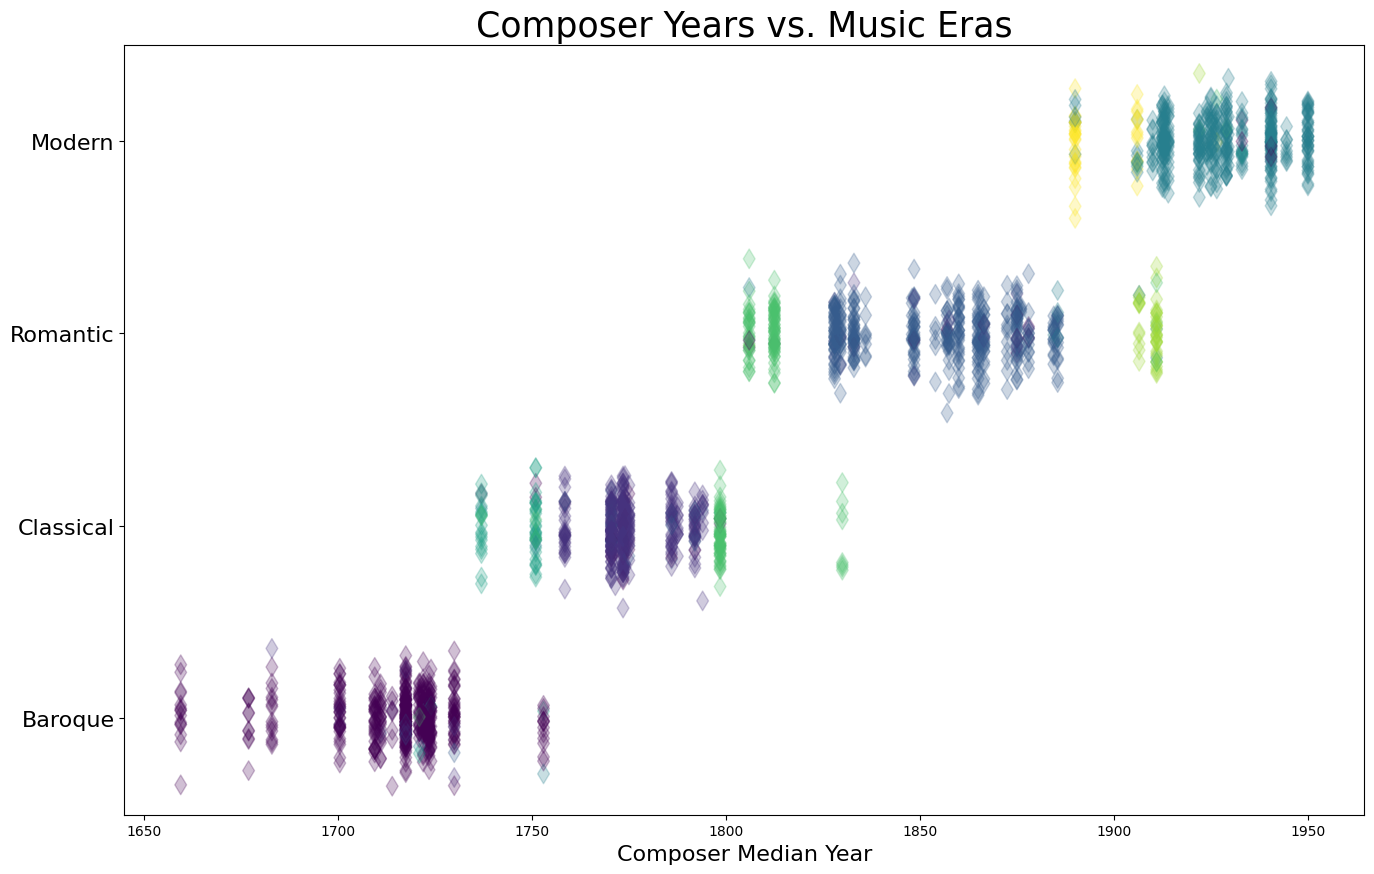

In [694]:
predict_gran = hgb_classifier_gran.predict(X_gran)

fig, ax = plt.subplots(figsize = (16, 10))
ax.scatter(composer_years, piece_eras, c = predict_gran, alpha = 0.25, s = 100, marker = "d")
ax.set_ylim(0.5, 4.5)
ax.set_yticks([1, 2, 3, 4])
ax.set_yticklabels(["Baroque", "Classical", "Romantic", "Modern"], fontsize = 16)
ax.set_title('Composer Years vs. Music Eras', fontsize = 25)
ax.set_xlabel("Composer Median Year", fontsize = 16)
plt.savefig('Eras_Classification_WithAddon.png')

plt.show()

In [507]:
keep_noaddon = pd.Series([pieces_info[piece][4] for piece in keep_pieces]) == -1

y_gpt = data_transitions_gpt['era']

X_noaddon = X[keep_noaddon]
y_noaddon = y[keep_noaddon]

X_addon = X[-keep_noaddon]
y_addon = y[-keep_noaddon]
y_addon_gpt = y_gpt[-keep_noaddon]

predictions_addon = hgb_classifier.predict(X_addon)

print(len([(predictions_addon[i], y_addon.iloc[i]) for i in range(len(y_addon)) if predictions_addon[i] != y_addon.iloc[i]]))
print(len([(predictions_addon[i], y_addon_gpt.iloc[i]) for i in range(len(y_addon_gpt)) if predictions_addon[i] != y_addon_gpt.iloc[i]]))

301
292


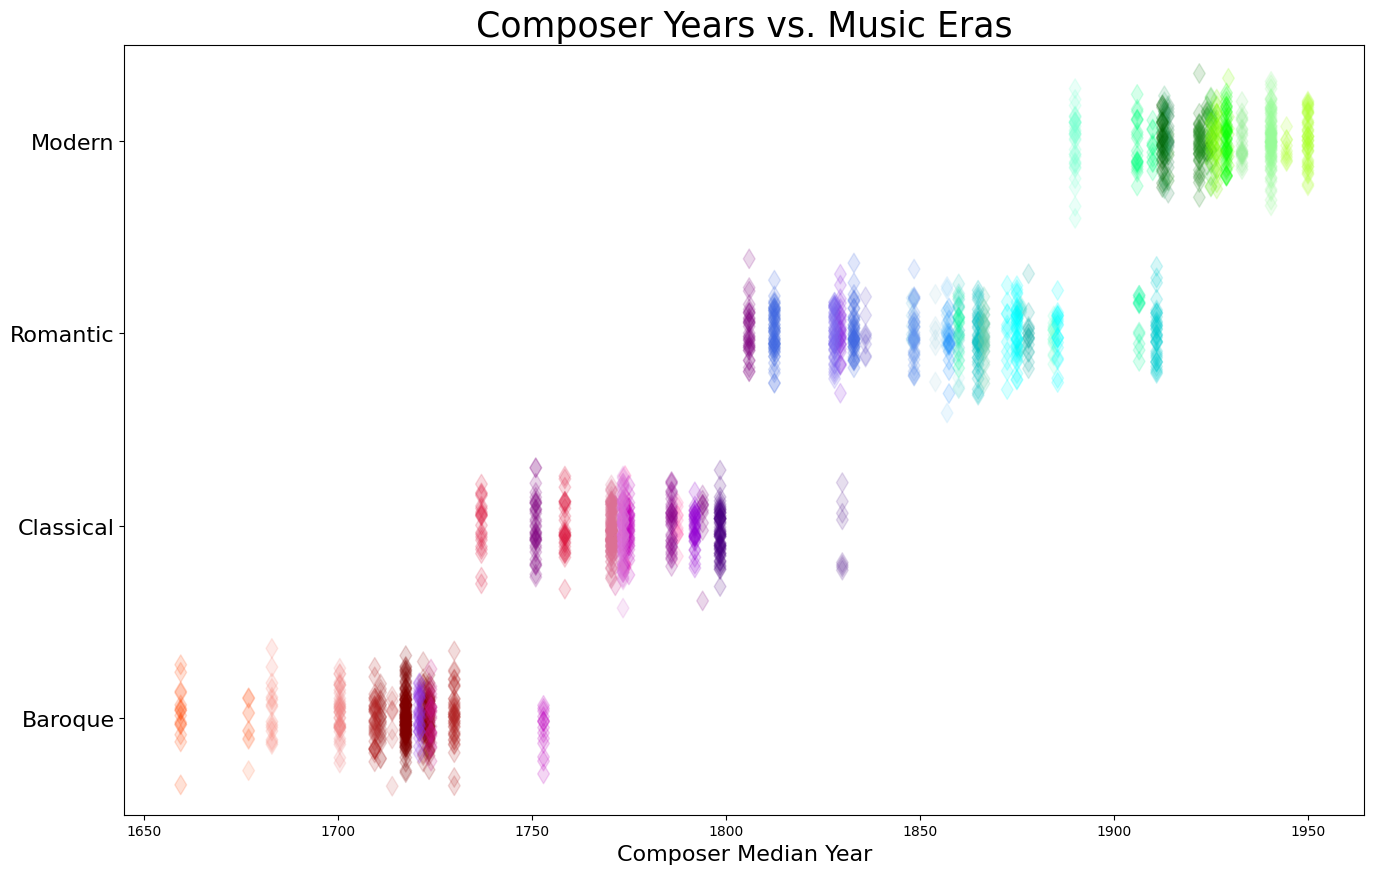

In [674]:
X = data_transitions[data_transitions.columns[1:]]
y = data_transitions['era']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
        
hgb_classifier = HistGradientBoostingClassifier(categorical_features = ['instrumentation', 'key', 'mode', 'first_chord', 'last_chord'],
                                                        learning_rate = 0.1, 
                                                        max_leaf_nodes = 10,
                                                        tol = 1e-5,)
        
hgb_classifier.fit(X_train, y_train)
hgb_classifier.score(X_test, y_test)




composer_list = [pieces_data[piece][5] for piece in keep_pieces]

from collections import defaultdict

composer_colors = {"Lully; Jean-Baptiste" : "orangered", "Purcell; Henry" : "coral", "Corelli; Arcangelo" : "salmon", "Couperin; Francois" : "lightcoral", "Giustini; Lodovico" : "indianred", "Vivaldi; Antonio" : "firebrick", "Handel; George Frederic" : "brown", "Bach; Johann Sebastian" : "maroon", "Rameau; Jean-Phillipe" : "darkred", "Albinoni; Tomaso" : "brown", "Platti; Giovanni Benedetto" : "firebrick", "Bach; Johann Christian" : "crimson", "Boccherini; Luigi Rodolofo" : "deeppink", "Haydn; Joseph" : "palevioletred", "Salieri; Antonio" : "hotpink", "Mozart; Wolfgang Amadeus" : "orchid", "Haydn; Johann Michael" : "mediumvioletred", "Cimarosa; Domenico" : "m", "Dussek; Jan Ladislav" : "darkmagenta", "Pleyel; Ignace Joseph" : "purple", "Clementi; Muzio" : "darkviolet", "Chopin; Frederic" : "blueviolet", "Mendelssohn-Bartholdy; Felix" : "mediumslateblue", "Berlioz; Hector" : "slateblue", "Schumann; Robert" : "royalblue", "Liszt; Franz" : "cornflowerblue", "Schumann; Clara" : "dodgerblue", "Verdi; Giuseppe" : "lightskyblue", "Wagner; Richard" : "skyblue", "Smetana; Bedrich" : "lightblue", "Borodin; Alexander" : "paleturquoise", "Bruckner; Anton" : "mediumturquoise", "Rimsky-Korsakov; Nicolai" : "turquoise", "Saint-Saens; Camille" : "lightseagreen", "Tchaikovsky; Peter Iljitsch" : "mediumaquamarine", "Brahms; Johannes" : "c", "Dvorak; Antonin" : "darkturquoise", "Dvorak; Antonin" : "cyan", "Grieg; Edvard" : "aqua", "Faure; Gabriel" : "aquamarine", "Mussorgsky; Modest" : "mediumspringgreen", "Berg; Alban" : "springgreen", "Bartok; Bela" : "mediumseagreen", "Webern; Anton" : "seagreen", "Ives; Charles Edward" : "g", "Schoenberg; Arnold" : "darkgreen", "Varese; Edgar" : "green", "Prokofiew; Sergej" : "forestgreen", "Weill; Kurt" : "limegreen", "Hindemith; Paul" : "lime", "Stravinsky; Igor" : "lawngreen", "Milhaud; Darius" : "lightgreen", "Shostakovich; Dmitri" : "palegreen", "Messiaen; Olivier" : "greenyellow", "Antheil; George" : "chartreuse", "Britten; Benjamin" : "greenyellow", "Boulez; Pierre" : "lawngreen", "Bach; Carl Philipp Emanuel" : "purple", "Beethoven; Ludwig van" : "indigo", "Debussy; Claude" : "aquamarine", "Mahler; Gustav" : "cyan", "Mozart; Leopold" : "m", "Ravel; Maurice" : "springgreen", "Rossini; Gioacchino" : "rebeccapurple", "Scarlatti; Domenico" : "blueviolet", "Schubert; Franz" : "royalblue", "Sibelius; Jean" : "darkturquoise", "Stamitz; Johann" : "crimson", "Strauss; Richard" : "mediumspringgreen", "Telemann; Georg Philipp" : "mediumvioletred", "Weber; Carl Maria von" : "purple"}
composer_colors = defaultdict(lambda:"black", composer_colors)

colors = [composer_colors[composer] for composer in composer_list]

composer_years = []

y_gpt = data_transitions_gpt['era']

for piece in keep_pieces :
    composer = pieces_composers[piece]
    try :
        year1 = float(composer[1])
        try :
            year2 = float(composer[2])
            
        except ValueError :
            year2 = year1
            
        year = 1/2 * (year1 + year2)
        composer_years.append(year)
    except :
        pass

composer_years = [year + np.random.uniform(0, 0.01, 1) for year in composer_years]

piece_eras = (y_gpt + np.random.normal(0, 0.12, len(y_gpt)))
piece_eras_gran = (y_gpt + np.random.normal(0, 0.12, len(y_gpt)))

fig, ax = plt.subplots(figsize = (16, 10))
ax.scatter(composer_years, piece_eras, color = colors, alpha = 0.16, s = 100, marker = "d")
ax.set_ylim(0.5, 4.5)

ax.set_yticks([1, 2, 3, 4])
ax.set_yticklabels(["Baroque", "Classical", "Romantic", "Modern"], fontsize = 16)
ax.set_title('Composer Years vs. Music Eras', fontsize = 25)
ax.set_xlabel("Composer Median Year", fontsize = 16)
plt.savefig('Eras_Composers_Visualization.png')

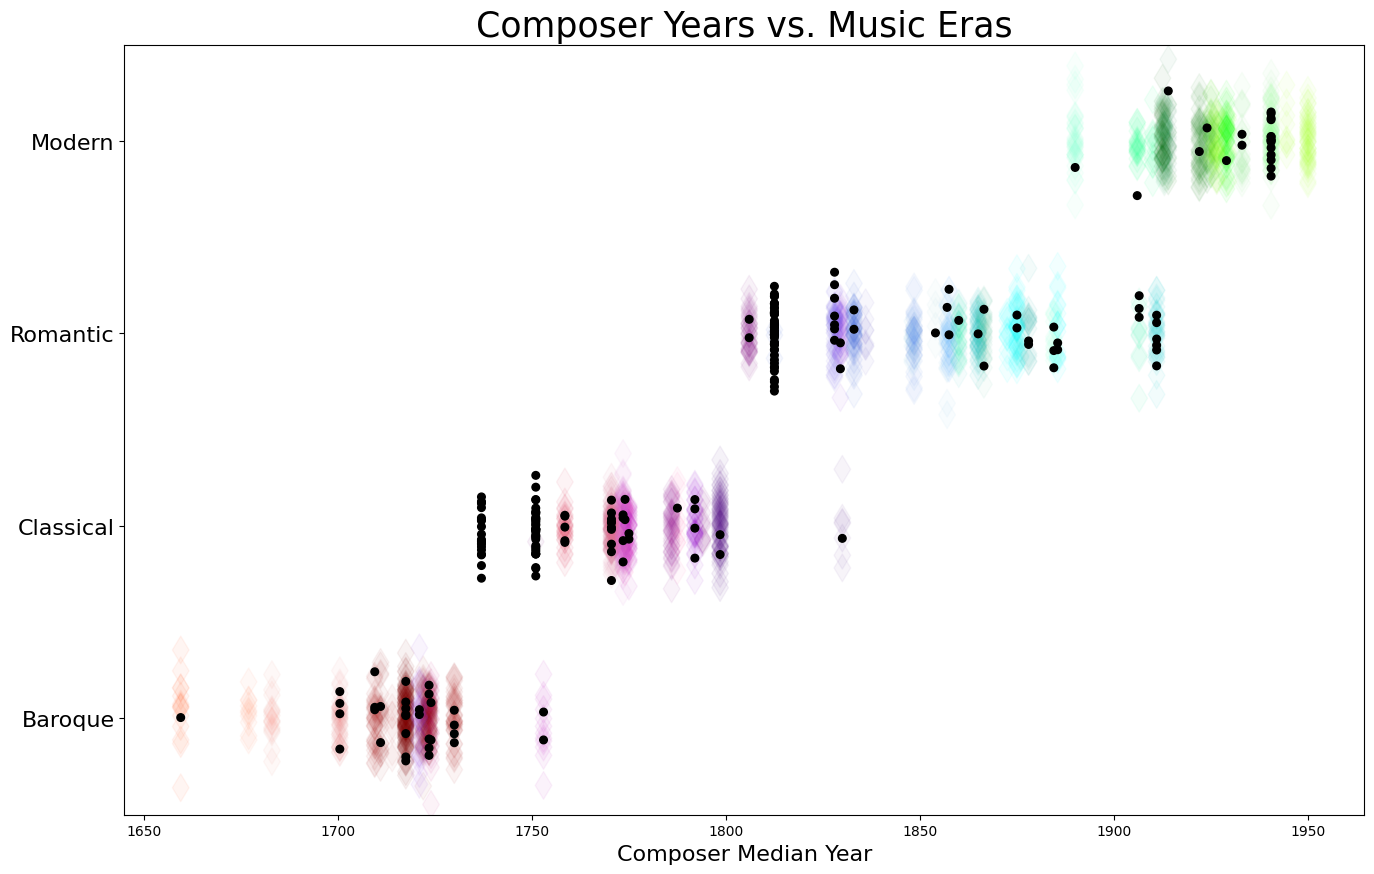

In [780]:
predicted = hgb_classifier.predict(X)

new_colors = []

for i in range(len(y_gpt)) :
    if predicted[i] != y_gpt[i] :
        new_colors.append("black")
    else :
        new_colors.append(colors[i])


piece_eras = 2 * (y_gpt + np.random.normal(0, .12, len(y_gpt)))

colors_data = pd.concat([pd.Series(composer_years), pd.Series(piece_eras), pd.Series(new_colors)], axis = 1)
colors_correct = colors_data[colors_data[1] != "black"]
colors_incorrect = colors_data[colors_data[1] == "black"]

fig, ax = plt.subplots(figsize = (16, 10))
ax.scatter(colors_correct[0], colors_correct['era'], color = colors_correct[1], alpha = 0.05, s = 200, marker = "d")
ax.scatter(colors_incorrect[0], colors_incorrect['era'], color = colors_incorrect[1], alpha = 1.0, s = 30, marker = "o")
ax.set_ylim(1, 9)
ax.set_yticks([2, 4, 6, 8])
ax.set_yticklabels(["Baroque", "Classical", "Romantic", "Modern"], fontsize = 16)
ax.set_title('Composer Years vs. Music Eras', fontsize = 25)
ax.set_xlabel("Composer Median Year", fontsize = 16)
plt.savefig('Eras_Classification_GPT.png')

In [860]:
X = data_transitions[data_transitions.columns[1:]]
y = data_transitions['era']

X_noaddon = X[keep_noaddon]
y_noaddon = y[keep_noaddon]

X_train, X_test, y_train, y_test = train_test_split(X_noaddon, y_noaddon, test_size = 0.2)

hgb_classifier = HistGradientBoostingClassifier(categorical_features = ['instrumentation', 'key', 'mode', 'first_chord', 'last_chord'],
                                                        learning_rate = 0.1, 
                                                        max_leaf_nodes = 10,
                                                        tol = 1e-5,)

hgb_classifier.fit(X_train, y_train)
hgb_classifier.score(X_test, y_test)

0.7429467084639498

In [846]:
X = data_transitions_gpt[data_transitions_gpt.columns[1:]]
y = data_transitions_gpt['era']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

hgb_classifier.fit(X_train, y_train)
hgb_classifier.score(X_test, y_test)

0.6959798994974874

0.06984924623115578


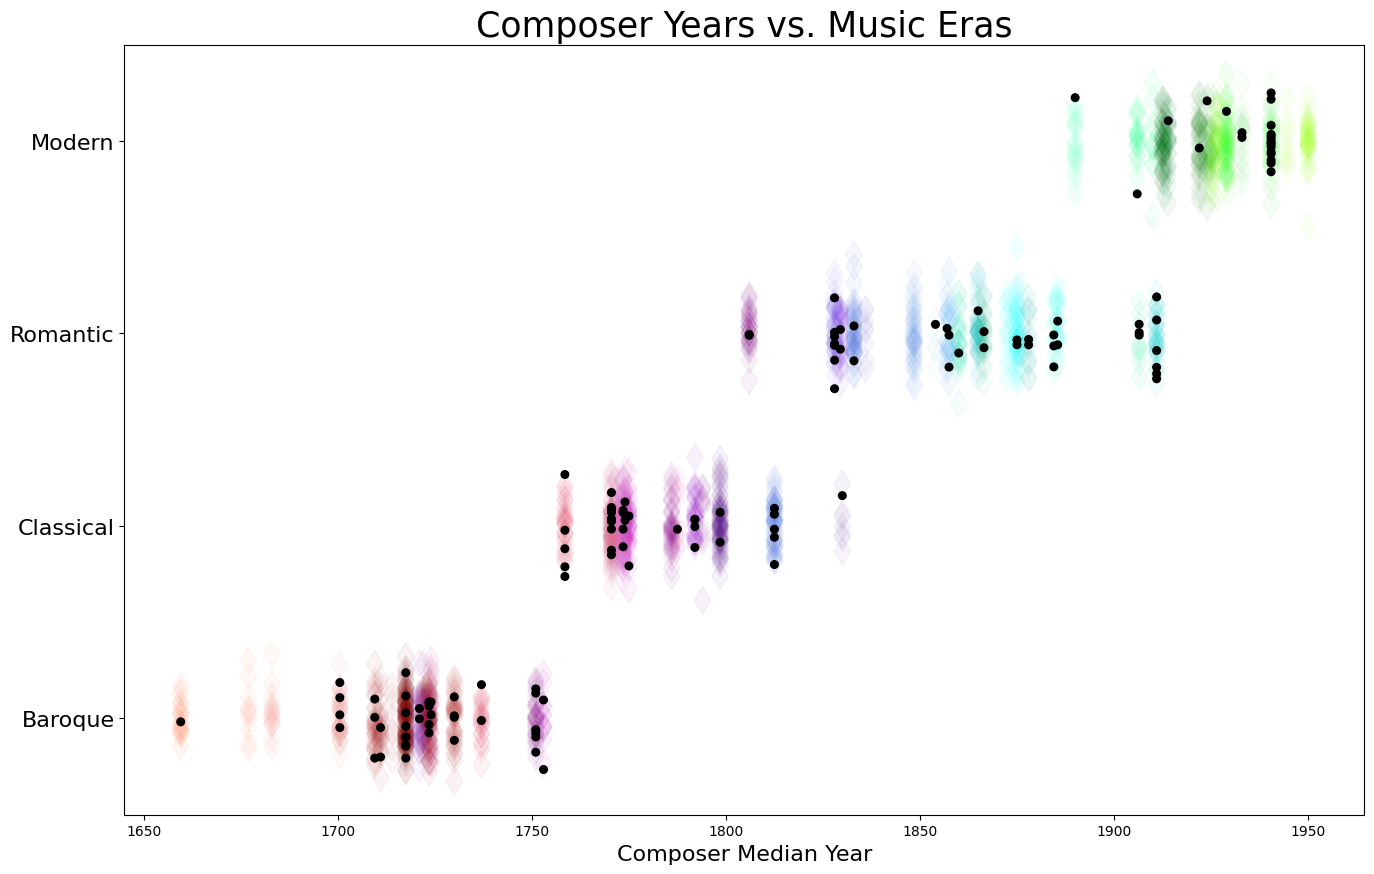

In [778]:
predicted = hgb_classifier.predict(X)

new_colors = []

for i in range(len(y)) :
    if predicted[i] != y[i] :
        new_colors.append("black")
    else :
        new_colors.append(colors[i])


piece_eras = 2 * (y + np.random.normal(0, .12, len(y)))

colors_data = pd.concat([pd.Series(composer_years), pd.Series(piece_eras), pd.Series(new_colors)], axis = 1)
colors_correct = colors_data[colors_data[1] != "black"]
colors_incorrect = colors_data[colors_data[1] == "black"]

fig, ax = plt.subplots(figsize = (16, 10))
ax.scatter(colors_correct[0], colors_correct['era'], color = colors_correct[1], alpha = 0.05, s = 200, marker = "d")
ax.scatter(colors_incorrect[0], colors_incorrect['era'], color = colors_incorrect[1], alpha = 1.0, s = 30, marker = "o")
ax.set_ylim(1, 9)
ax.set_yticks([2, 4, 6, 8])
ax.set_yticklabels(["Baroque", "Classical", "Romantic", "Modern"], fontsize = 16)
ax.set_title('Composer Years vs. Music Eras', fontsize = 25)
ax.set_xlabel("Composer Median Year", fontsize = 16)
# plt.savefig('Eras_Classification.png')
plt.show()

In [ ]:
keep_noaddon = pd.Series([pieces_info[piece][4] for piece in keep_pieces]) == -1

In [813]:
keep_noaddon = pd.Series([pieces_info[piece][4] for piece in keep_pieces]) == -1

X_noaddon = X[keep_noaddon]
y_noaddon = y[keep_noaddon]

X_addon = X[-keep_noaddon]
y_addon = X[-keep_noaddon]

In [499]:
X = data_transitions[list(data_transitions.columns)[1:]]
y = data_transitions['era']

X_train, X_test, y_train, y_test = train_test_split(X_noaddon, y_noaddon, test_size = 0.2)

hgb_classifier = HistGradientBoostingClassifier(categorical_features = ['instrumentation', 'key', 'mode', 'first_chord', 'last_chord'],
                                                    learning_rate = 0.1, 
                                                    max_leaf_nodes = 10,
                                                    tol = 1e-5,)
    
hgb_classifier.fit(X_train, y_train)

hgb_classifier.score(X_test, y_test)

0.7492163009404389

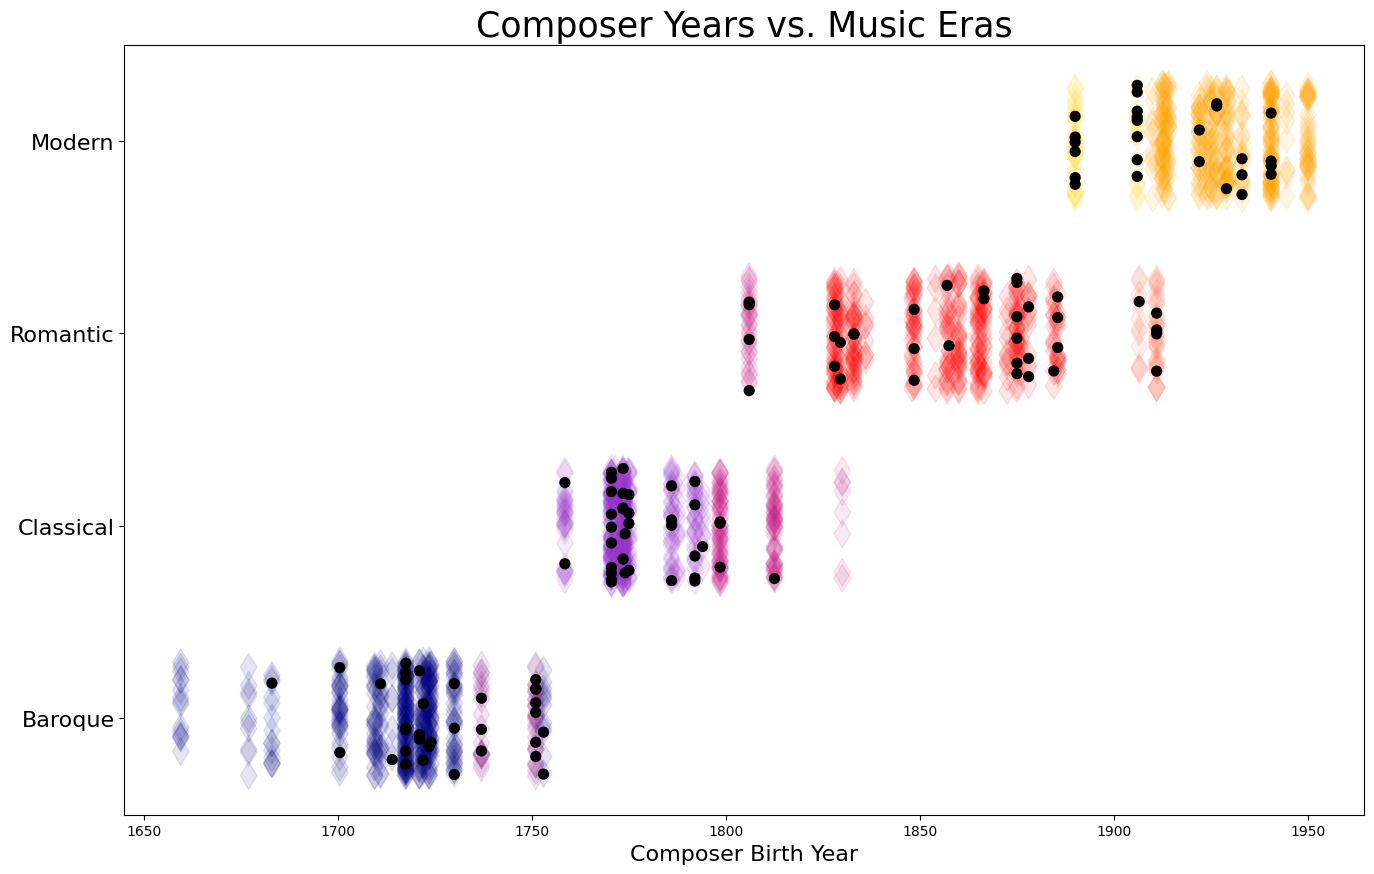

In [708]:
gran_color_mapping = {1:"navy", 5:"purple", 2:"darkorchid", 6:"mediumvioletred", 3:"red", 7:"tomato", 4:"orange", 8:"gold"}
gran_colors = [gran_color_mapping[color] for color in predict_gran]

new_colors = []

for i in range(len(y_gran)) :
    if predict_gran[i] != y_gran[i] :
        new_colors.append("black")
    else :
        new_colors.append(gran_colors[i])

piece_eras = data_transitions['era']
piece_eras = (piece_eras + np.random.uniform(-0.3, 0.3, len(piece_eras)))

colors_data = pd.concat([pd.Series(composer_years), pd.Series(piece_eras), pd.Series(new_colors)], axis = 1)
#colors_data = colors_data.loc[X_test.index]
colors_correct = colors_data[colors_data[1] != "black"]
colors_incorrect = colors_data[colors_data[1] == "black"]

fig, ax = plt.subplots(figsize = (16, 10))
ax.scatter(colors_correct[0], colors_correct['era'], color = colors_correct[1], alpha = 0.10, s = 200, marker = "d")
ax.scatter(colors_incorrect[0], colors_incorrect['era'], color = colors_incorrect[1], alpha = 1.0, s = 50, marker = "o")
ax.set_ylim(0.5, 4.5)
ax.set_yticks([1, 2, 3, 4])
ax.set_yticklabels(["Baroque", "Classical", "Romantic", "Modern"], fontsize = 16)
ax.set_title('Composer Years vs. Music Eras', fontsize = 25)
ax.set_xlabel("Composer Birth Year", fontsize = 16)
plt.savefig('Transitionary_Eras_Classification.png')

In [198]:
predictions = hgb_classifier.predict(X)

correctly_classified_gpt = [1 if predictions[i] == y_gpt.iloc[i] else 0 for i in range(len(predictions))]
correctly_classified = [1 if predictions[i] == y.iloc[i] else 0 for i in range(len(predictions))]

sum(correctly_classified_gpt) / len(correctly_classified_gpt), sum(correctly_classified) / len(correctly_classified)

(0.8954773869346734, 0.9422110552763819)

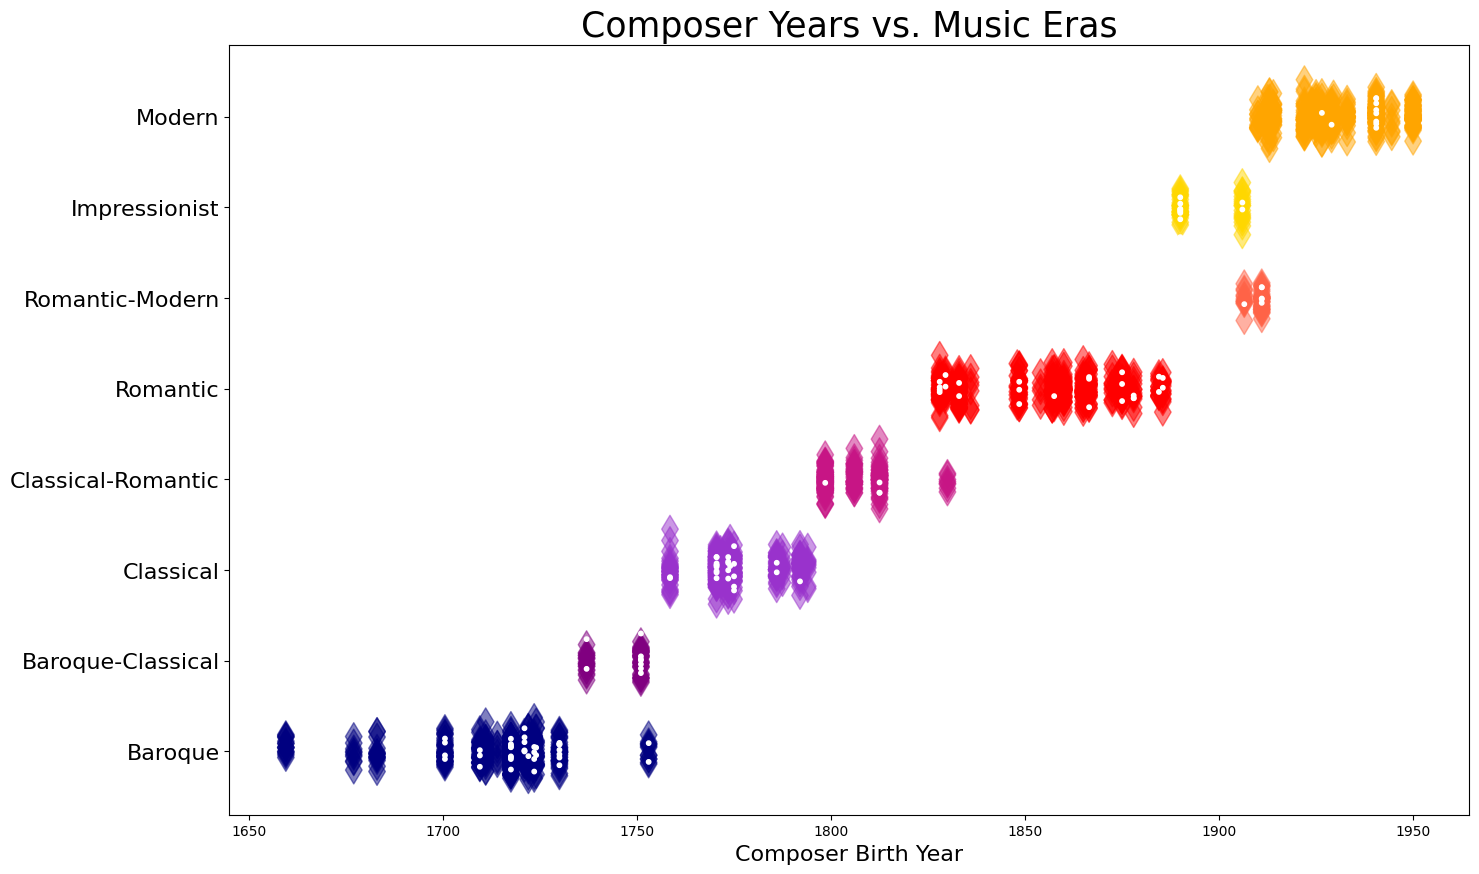

In [564]:
eras_gran_mapping = {1:1, 5:2,2:3, 6:4, 3:5, 7:6, 4:8, 8:7}

gran_color_mapping = {1:"navy", 5:"purple", 2:"darkorchid", 6:"mediumvioletred", 3:"red", 7:"tomato", 4:"orange", 8:"gold"}
gran_colors = [gran_color_mapping[color] for color in predict_gran]

new_colors = []

for i in range(len(y_gran)) :
    if predict_gran[i] != y_gran[i] :
        new_colors.append("white")
    else :
        new_colors.append(gran_colors[i])

piece_eras = data_transitions_gran['era'].map(lambda x: eras_gran_mapping[x])
piece_eras = (piece_eras + np.random.normal(0, .12, len(piece_eras)))

colors_data = pd.concat([pd.Series(composer_years), pd.Series(piece_eras), pd.Series(new_colors)], axis = 1)
#colors_data = colors_data.loc[X_test.index]
colors_correct = colors_data[colors_data[1] != "white"]
colors_incorrect = colors_data[colors_data[1] == "white"]

fig, ax = plt.subplots(figsize = (16, 10))
ax.scatter(colors_correct[0], colors_correct['era'], color = colors_correct[1], alpha = 0.5, s = 200, marker = "d")
ax.scatter(colors_incorrect[0], colors_incorrect['era'], color = colors_incorrect[1], alpha = 1.0, s = 10, marker = "o")
ax.set_yticks([1, 2, 3, 4, 5, 6, 7, 8])
ax.set_yticklabels(["Baroque", "Baroque-Classical", "Classical", "Classical-Romantic", "Romantic", "Romantic-Modern", "Impressionist", "Modern"], fontsize = 16)
ax.set_title('Composer Years vs. Music Eras', fontsize = 25)
ax.set_xlabel("Composer Birth Year", fontsize = 16)
plt.savefig('Transitionary_Eras_Classification2.png')


In [202]:
composer_list_new = pd.Series(composer_list)

correctly_classified_gpt = pd.Series([bool(val) for val in correctly_classified_gpt]) 
correctly_classified = pd.Series([bool(val) for val in correctly_classified]) 

composer_list_new[-correctly_classified_gpt].value_counts()

Schubert; Franz                 48
Bach; Carl Philipp Emanuel      36
Stamitz; Johann                 19
Shostakovich; Dmitri             9
Mozart; Wolfgang Amadeus         8
Mendelssohn-Bartholdy; Felix     7
Bach; Johann Sebastian           6
Beethoven; Ludwig van            6
Haydn; Joseph                    6
Grieg; Edvard                    6
Sibelius; Jean                   4
Rameau; Jean-Phillipe            4
Liszt; Franz                     4
Platti; Giovanni Benedetto       3
Boccherini; Luigi Rodolofo       3
Clementi; Muzio                  3
Saint-Saens; Camille             3
Brahms; Johannes                 2
Mahler; Gustav                   2
Strauss; Richard                 2
Debussy; Claude                  2
Milhaud; Darius                  2
Couperin; Francois               2
Cimarosa; Domenico               2
Schumann; Robert                 2
Verdi; Giuseppe                  2
Scarlatti; Domenico              2
Dussek; Jan Ladislav             1
Tchaikovsky; Peter I

In [204]:
composer_list_new[-correctly_classified].value_counts()

Shostakovich; Dmitri            9
Mozart; Wolfgang Amadeus        8
Mendelssohn-Bartholdy; Felix    7
Bach; Johann Sebastian          6
Beethoven; Ludwig van           6
Haydn; Joseph                   6
Grieg; Edvard                   6
Schubert; Franz                 5
Sibelius; Jean                  4
Rameau; Jean-Phillipe           4
Liszt; Franz                    4
Bach; Carl Philipp Emanuel      3
Platti; Giovanni Benedetto      3
Boccherini; Luigi Rodolofo      3
Clementi; Muzio                 3
Saint-Saens; Camille            3
Strauss; Richard                2
Stamitz; Johann                 2
Brahms; Johannes                2
Mahler; Gustav                  2
Debussy; Claude                 2
Milhaud; Darius                 2
Couperin; Francois              2
Cimarosa; Domenico              2
Schumann; Robert                2
Verdi; Giuseppe                 2
Scarlatti; Domenico             2
Dussek; Jan Ladislav            1
Tchaikovsky; Peter Iljitsch     1
Rossini; Gioac

In [371]:
from sklearn.cluster import SpectralClustering

data_dummies = pd.get_dummies(data_transitions)
data_dummies = data_dummies.fillna(0)

spectral_cluster = SpectralClustering(n_clusters = 8, affinity='nearest_neighbors')
clusters = spectral_cluster.fit_predict(data_dummies)

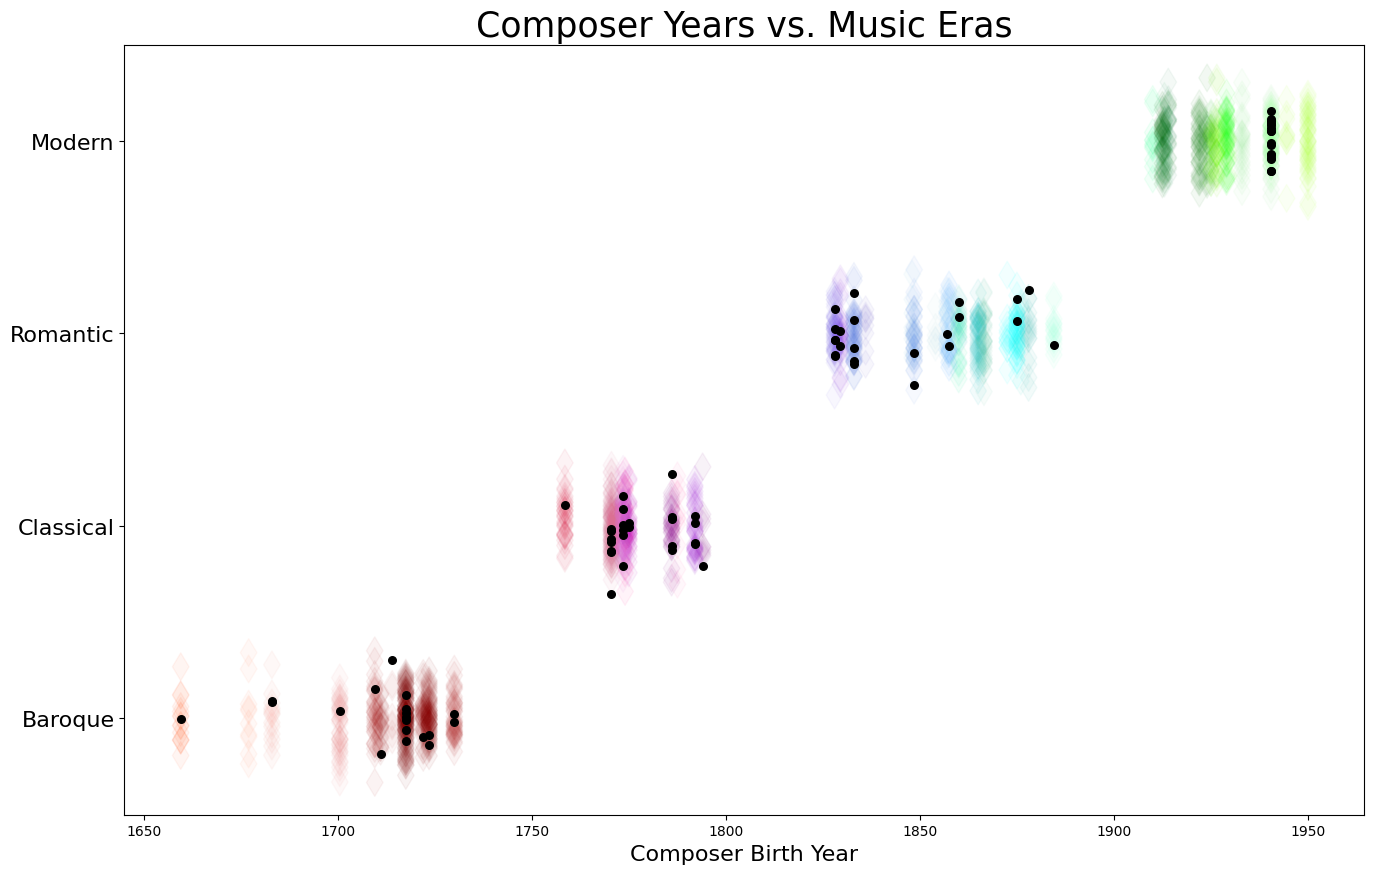

In [776]:
X = data_transitions[data_transitions.columns[1:]]
y = data_transitions['era']

X_train, X_test, y_train, y_test = train_test_split(X_noaddon, y_noaddon, test_size = 0.2)
        
hgb_classifier_noaddon = HistGradientBoostingClassifier(categorical_features = ['instrumentation', 'key', 'mode', 'first_chord', 'last_chord'],
                                                        learning_rate = 0.1, 
                                                        max_leaf_nodes = 10,
                                                        tol = 1e-5,)
        
hgb_classifier_noaddon.fit(X_train, y_train)
predicted = hgb_classifier_noaddon.predict(X_noaddon)

new_colors = []

for i in range(len(y_noaddon)) :
    if predicted[i] != y_noaddon[i] :
        new_colors.append("black")
    else :
        new_colors.append(colors[i])


piece_eras = 2 * (y_noaddon + np.random.normal(0, .12, len(y_noaddon)))

colors_data = pd.concat([pd.Series(composer_years)[keep_noaddon], pd.Series(piece_eras), pd.Series(new_colors)], axis = 1)
colors_correct = colors_data[colors_data[1] != "black"]
colors_incorrect = colors_data[colors_data[1] == "black"]

fig, ax = plt.subplots(figsize = (16, 10))
ax.scatter(colors_correct[0], colors_correct['era'], color = colors_correct[1], alpha = 0.05, s = 200, marker = "d")
ax.scatter(colors_incorrect[0], colors_incorrect['era'], facecolors='black', edgecolors='black', alpha = 1.0, s = 30, marker = "o")


ax.set_ylim(1, 9)
ax.set_yticks([2, 4, 6, 8])
ax.set_yticklabels(["Baroque", "Classical", "Romantic", "Modern"], fontsize = 16)
ax.set_title('Composer Years vs. Music Eras', fontsize = 25)
ax.set_xlabel("Composer Birth Year", fontsize = 16)
#plt.savefig('Eras_Classification_NoAddon.png')
plt.show()

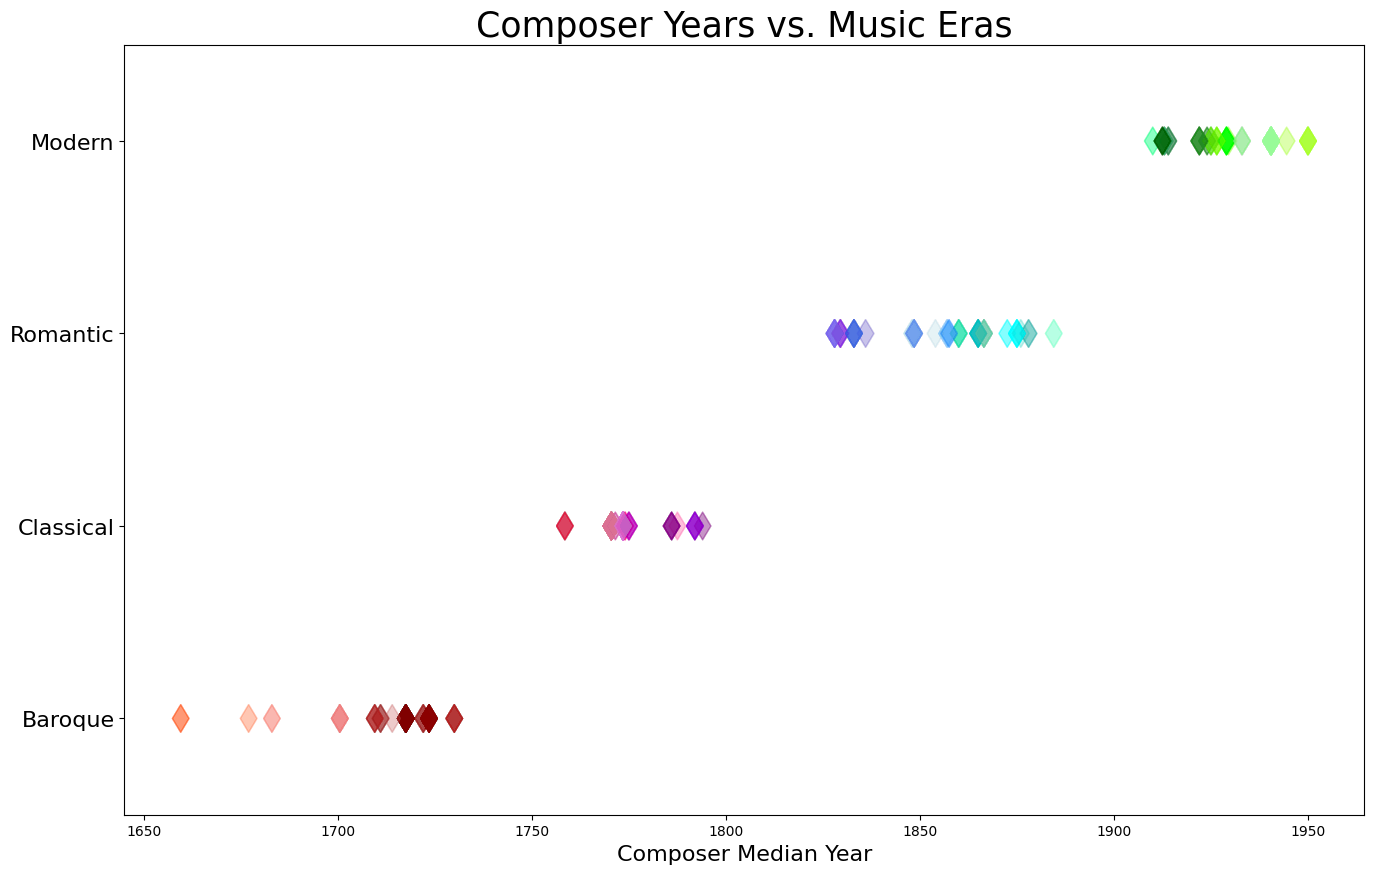

In [871]:
X = data_transitions[data_transitions.columns[1:]]
y = data_transitions['era']

X_train, X_test, y_train, y_test = train_test_split(X_noaddon, y_noaddon, test_size = 0.2)
        
hgb_classifier_noaddon = HistGradientBoostingClassifier(categorical_features = ['instrumentation', 'key', 'mode', 'first_chord', 'last_chord'],
                                                        learning_rate = 0.1, 
                                                        max_leaf_nodes = 10,
                                                        tol = 1e-5,)
        
hgb_classifier_noaddon.fit(X_train, y_train)
predicted = hgb_classifier_noaddon.predict(X_noaddon)

new_colors = []

for i in range(len(y_noaddon)) :
    if predicted[i] != y_noaddon[i] :
        new_colors.append("black")
    else :
        new_colors.append(colors[i])


piece_eras = 2 * y_noaddon#(y_noaddon + np.random.normal(0, .12, len(y_noaddon)))

colors_data = pd.concat([pd.Series(composer_years)[keep_noaddon], pd.Series(piece_eras), pd.Series(new_colors)], axis = 1)
colors_correct = colors_data[colors_data[1] != "black"]
colors_incorrect = colors_data[colors_data[1] == "black"]

fig, ax = plt.subplots(figsize = (16, 10))
ax.scatter(colors_correct[0], colors_correct['era'], color = colors_correct[1], alpha = 0.05, s = 200, marker = "d")
# ax.scatter(colors_incorrect[0], colors_incorrect['era'], facecolors='black', edgecolors='black', alpha = 1.0, s = 30, marker = "o")
ax.set_ylim(1, 9)
ax.set_yticks([2, 4, 6, 8])
ax.set_yticklabels(["Baroque", "Classical", "Romantic", "Modern"], fontsize = 16)
ax.set_title('Composer Years vs. Music Eras', fontsize = 25)
ax.set_xlabel("Composer Median Year", fontsize = 16)
#plt.savefig('Eras_Composers_1.png')
plt.show()

In [867]:
len(set(composer_list))

70